In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *

In [2]:
#                       PREPROCESSING PARAMETERS
#======================================================================================
plot = False
FS_ORIG = 2048  # Hz

# Printing general info
print_info = False

# Notch filtering
notch_applied = True
freq_notch = 50

# Bandpass filtering
bpf_applied = True
freq_low   = 1
freq_high  = 15
bandpass = str(freq_low) + '-' + str(freq_high)
ftype = 'butter'
order = 3

# Spherical interpolation
int_applied = False
interpolation = 'spline'

# Rereferencing using average of mastoids electrodes
reref_applied = True
reref_type = 'Mastoids'  #Mastoids #Average

# Downsampling
down_applied = True
downfreq = 128
if not down_applied:
    downfreq = FS_ORIG
downfreq_factor = int(FS_ORIG/downfreq)


#INFO ABOUT TRIALS
#trial durations
listen_dur = 665
motor_dur = 600
error_dur = 600



In [3]:
#                        INITIALIZE DIRECTORIES
#======================================================================================
root_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw" #where the raw bdf files are
output_base = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed' #where all the preprocessed .mat files and other info go


#fs was 1024 for participant 03

## Start here

Extracting EDF parameters from /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1248255  =      0.000 ...  1218.999 secs...
Trigger channel has a non-zero initial value of 130816 (consider using initial_event=True to detect this event)
106366 events found
Event IDs: [65282 65328 65535]
Some event types missing. Check data.


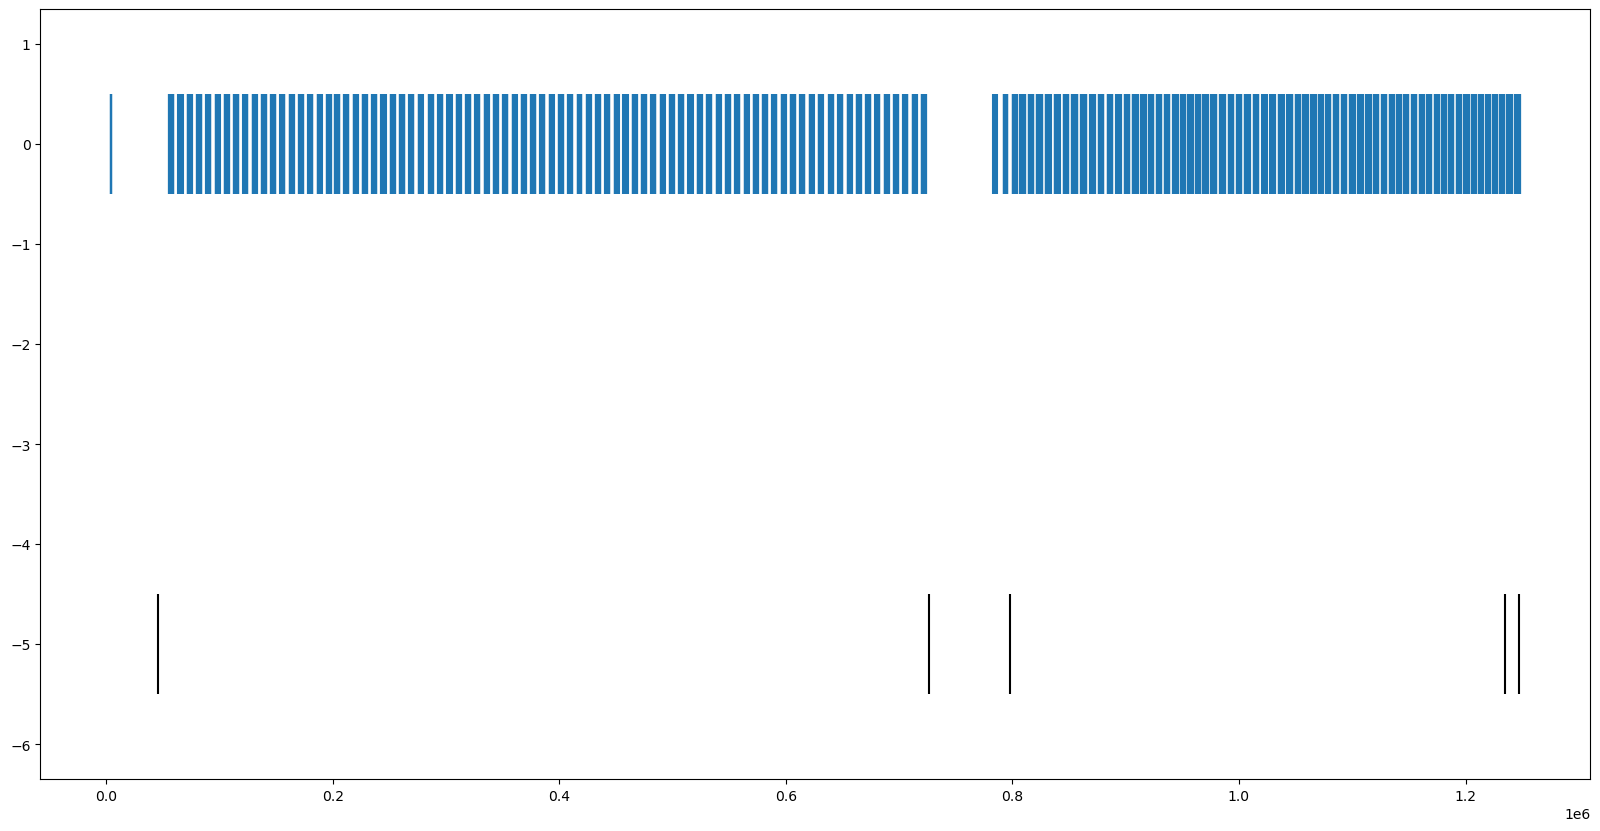

In [4]:
#======================================================================================
#                           CHECK TRIGGERS
#======================================================================================


file = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_raw/sub_03/sub_03_03.bdf'

#load file
raw = mne.io.read_raw_bdf(file, eog=None, misc=None, stim_channel='Status', 
                              infer_types=False, preload=True, verbose=None)

events = mne.find_events(raw, stim_channel='Status', shortest_event=1)
events_2, events_3, events_4, events_5, events_6, trial_starts = sort_events(events)
subject_ID = file.split('/')[-2][-2:]

#exception for subject 3
if subject_ID == '03':
    FS_ORIG = 1024
    downfreq_factor = int(FS_ORIG/downfreq)


#check events
plot_subset = False
start = 0
end = 100


plt.figure(figsize = (20,10))

if plot_subset:
#keystrokes
    plt.eventplot(events_2[:,0][start:end], lineoffsets = 0)
    plt.eventplot(events_3[:,0][start:end], color = 'green', lineoffsets = -2)
    plt.eventplot(events_4[:,0][start:end], color = 'orange', lineoffsets = -3)
    plt.eventplot(events_5[:,0][start:end], color = 'red', lineoffsets=-4)
else:
    plt.eventplot(events_2[:,0], lineoffsets = 0)
    plt.eventplot(events_3[:,0], color = 'green', lineoffsets = -2)
    plt.eventplot(events_4[:,0], color = 'orange', lineoffsets = -3)
    plt.eventplot(events_5[:,0], color = 'red', lineoffsets=-4)
    plt.eventplot(events_6[:,0], color = 'black', lineoffsets=-5)
    plt.eventplot(trial_starts[:,0], color = 'grey', lineoffsets=-6)

plt.show()


In [7]:
#           MODIFY THIS PART
#-----------------------------------------------------------

task = 'motor'
period = 'post'

#BAD CHANNELS
raw.info['bads'] = []

start_idx = 2

task_start = events_6[:,0][start_idx]/FS_ORIG #use events_6 instead of trial_starts for subject 2
#task_start = trial_starts[:,0][start_idx]/FS_ORIG

#-----------------------------------------------------------------



#======================================================================================
#                        CROPPING FILES TO THE TRIAL
#======================================================================================

eeg_name = f'eeg_{task}_{period}'


if task == 'listen':
    task_end = task_start + 665
else:
    task_end = task_start + 600

#end of recording
recording_end = raw.times.max() - 10

if recording_end < task_end: 
    task_end = recording_end

data = raw.copy().crop(tmin = task_start, tmax = task_end)



In [8]:

#======================================================================================
#                        PREPROCESS
#======================================================================================
df_pre = pd.DataFrame()

output_dir = os.path.join(output_base, subject_ID)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Check metadata
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names) 


#======================================================================================
#                       FILTERING
#======================================================================================

## -------------
## Select channels
## -------------

#eeg_channels = ch_names[:66] + [ch_names[-1]]
eeg_channels = ch_names[0:72]
eeg = data.copy().pick_channels(eeg_channels)
if plot:
    eeg.plot(start=100, duration=10, n_channels=len(raw.ch_names))

## -------------
## Notch filtering
## -------------
df_pre['notch_applied'] = [notch_applied]
if notch_applied:
    eeg = eeg.notch_filter(freqs=freq_notch)
    df_pre['notch'] = [freq_notch]
    if plot:
        eeg.plot()

## -------------
## BPFiltering
## -------------
df_pre['bpf_applied'] = [bpf_applied]
if bpf_applied:
    iir_params = dict(order=order, ftype=ftype)
    filter_params = mne.filter.create_filter(eeg.get_data(), eeg.info['sfreq'], 
                                            l_freq=freq_low, h_freq=freq_high, 
                                            method='iir', iir_params=iir_params)

    if plot:
        flim = (1., eeg.info['sfreq'] / 2.)  # frequencies
        dlim = (-0.001, 0.001)  # delays
        kwargs = dict(flim=flim, dlim=dlim)
        mne.viz.plot_filter(filter_params, eeg.info['sfreq'], compensate=True, **kwargs)
        # plt.savefig(os.path.join(output_dir, 'bpf_ffilt_shape.png'))

    eeg = eeg.filter(l_freq=freq_low, h_freq=freq_high, method='iir', iir_params=iir_params)
    df_pre['bandpass'] = [iir_params]
    df_pre['HPF'] = [freq_low]
    df_pre['LPF'] = [freq_high]
    if plot:
        eeg.plot()

    
    ## -------------
    ## Interpolation
    ## -------------
    df_pre['int_applied'] = [int_applied]
    if int_applied: 
        eeg = eeg.interpolate_bads(reset_bads=False)  #, method=interpolation

        # Get the indices and names of the interpolated channels
        interp_inds = eeg.info['bads']
        interp_names = [eeg.info['ch_names'][i] for i in interp_inds]

        # Print the number and names of the interpolated channels
        print(f'{len(interp_inds)} channels interpolated: {interp_names}')

        df_pre['interpolation'] = [interpolation]
        df_pre['interp_inds'] = [interp_inds]
        df_pre['interp_names'] = [interp_names]

        if plot:
            eeg.plot()
        
    
## -------------
## Rereferencing
## -------------
df_pre['reref_applied'] = [reref_applied]
if reref_applied:
    # Set electrodes for rereferencing
    if reref_type == 'Mastoids':
        if 'M1' in eeg.ch_names:
            reref_channels = ['M1', 'M2']
        else: 
            reref_channels = ['EXG1', 'EXG2']
    else:
        reref_channels = 'average'           

    # Actually r-referencing signals
    eeg = eeg.set_eeg_reference(ref_channels=reref_channels)
    df_pre['reref_type'] = [reref_type]
    df_pre['reref_channels'] = [reref_channels]
    if plot:
        eeg.plot()

    
## -------------
## Downsampling
## -------------
df_pre['down_applied'] = [down_applied]
df_pre['downfreq'] = [downfreq]
if down_applied:
    eeg = eeg.resample(sfreq=downfreq)
    if plot:
        eeg.plot()


#======================================================================================
#                      UPDATE TRIGGERS
#======================================================================================

#create support vectors
#zero array with downsampled dimensions
events_original = np.zeros((5, data.get_data().shape[1])) #5 rows = event types, along time axis zero when there is an event and 1 everywhere else


#get triggers
section_triggers = mne.find_events(data, stim_channel='Status', shortest_event=1)
events_2, events_3, events_4, events_5, events_6, section_start = sort_events(section_triggers, clean = True)

#get trial start time

    
try:
    section_start = section_start[0][0]
except IndexError: 
    section_start = events_6[0][0]


#find indices corrected for start time
indices_2 = (events_2[:,0]) - section_start
indices_3 = (events_3[:,0]) - section_start
indices_4 = (events_4[:,0]) - section_start
indices_5 = (events_5[:,0]) - section_start   

#populate event array with 1s where there are events

events_original[0][indices_2] = 1
events_original[1][indices_3] = 1
events_original[2][indices_4] = 1
events_original[3][indices_5] = 1

#resample while preserving events
cropped_length = eeg.get_data().shape[1]
events_resampled = np.zeros((5, cropped_length))
for row in range(events_resampled.shape[0]):
    events_resampled[row] = discretize(events_original[row], final_length = cropped_length, downfreq_factor = downfreq_factor)

#======================================================================================
#                       SAVING CROPPED FILES
#======================================================================================

name = eeg_name
eeg_tosave = eeg.get_data()


savemat(os.path.join(output_dir,f'{name}_{subject_ID}.mat'), 
        {'all_electrodes': eeg_tosave[0:72], 
            'trial_data': eeg_tosave[0:64, :], 
            'trial_mastoids': eeg_tosave[64:66, :], 
            'trial_exg': eeg_tosave[66:72, :], 
            'events': events_resampled})

    ## -------------
## Save preprocessing stages
## -------------

df_pre.to_csv(os.path.join(output_dir, f"preprocess_record_{name}_{subject_ID}.csv"), index=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up band-pass filter from 1 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 15.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoffs at 1.00, 15.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65328 (consider using initial_event=True to detect this event)
44773 events found
Event IDs: [65282 65328 65535]
Some event types missing. Check data.


In [120]:
downfreq

128

In [121]:
FS_ORIG

2048

In [122]:
downfreq_factor

16